In [35]:
'''
Library declare
@Author: MinHyung Lee
@Since: 2022/05/22
Used library:
pandas
numpy
featuretools
matplot
sklearn
seaborn

'''

import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

'''
Add plt config
@Author: MinHyung Lee
@Since: 2022/05/24

'''

plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
rcParams['figure.dpi'] = 600

pd.set_option('display.max_rows', 20)

random_state = 7777

In [36]:
X = pd.read_csv("preprocessed_feature.csv", index_col=[0])
y = pd.read_csv("targetForKNN.csv", index_col=[0])

In [37]:
#Load preprocessed dataset
#Split dataset into test and train set using stratify option

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,  random_state=random_state
)

In [38]:
def plotKNN(knn_model):


    # Reduce dimension to 2 with PCA
    pca = make_pipeline(PCA(n_components=2))

    # Use a nearest neighbor classifier to evaluate the methods
    knn = knn_model

    # Make a list of the methods to be compared
    dim_reduction_methods = [("PCA", pca)]

    # plt.figure()
    for i, (name, model) in enumerate(dim_reduction_methods):
        plt.figure()

        # Fit the method's model
        model.fit(X_train, y_train)

        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(model.transform(X_train), y_train)

        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(model.transform(X_test), y_test)

        # Embed the data set in 2 dimensions using the fitted model
        X_embedded = model.transform(X_test)

        # Plot the projected points and show the evaluation score
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test["Installs"], cmap="Set1")
        plt.title(
            "{}, KNN (k={})\nTest score = {:.2f}".format(name, knn.n_neighbors, acc_knn)
        )
    plt.show()

In [39]:
#Create KNN model
knn = KNeighborsClassifier()
#Set Kfold for k == 5
cv = KFold(n_splits=5)

fold = 0
for train_index, test_index in cv.split(X_test):

    fold += 1
    train_X, test_X = X_train.iloc[train_index], X_test.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_test.iloc[test_index]


    #Predict value by KNN when k == 5
    model_n_7 = KNeighborsClassifier(n_neighbors = 5)
    model_n_7.fit(train_X, train_y)

    print(f'Result of {fold} fold')
    print(f'Result when k == 5 => {model_n_7.score(test_X, test_y)}')

Result of 1 fold
Result when k == 5 => 0.14285714285714285
Result of 2 fold
Result when k == 5 => 0.14947089947089948
Result of 3 fold
Result when k == 5 => 0.17328042328042328
Result of 4 fold
Result when k == 5 => 0.176158940397351
Result of 5 fold
Result when k == 5 => 0.18675496688741722


--------With GridSearch--------


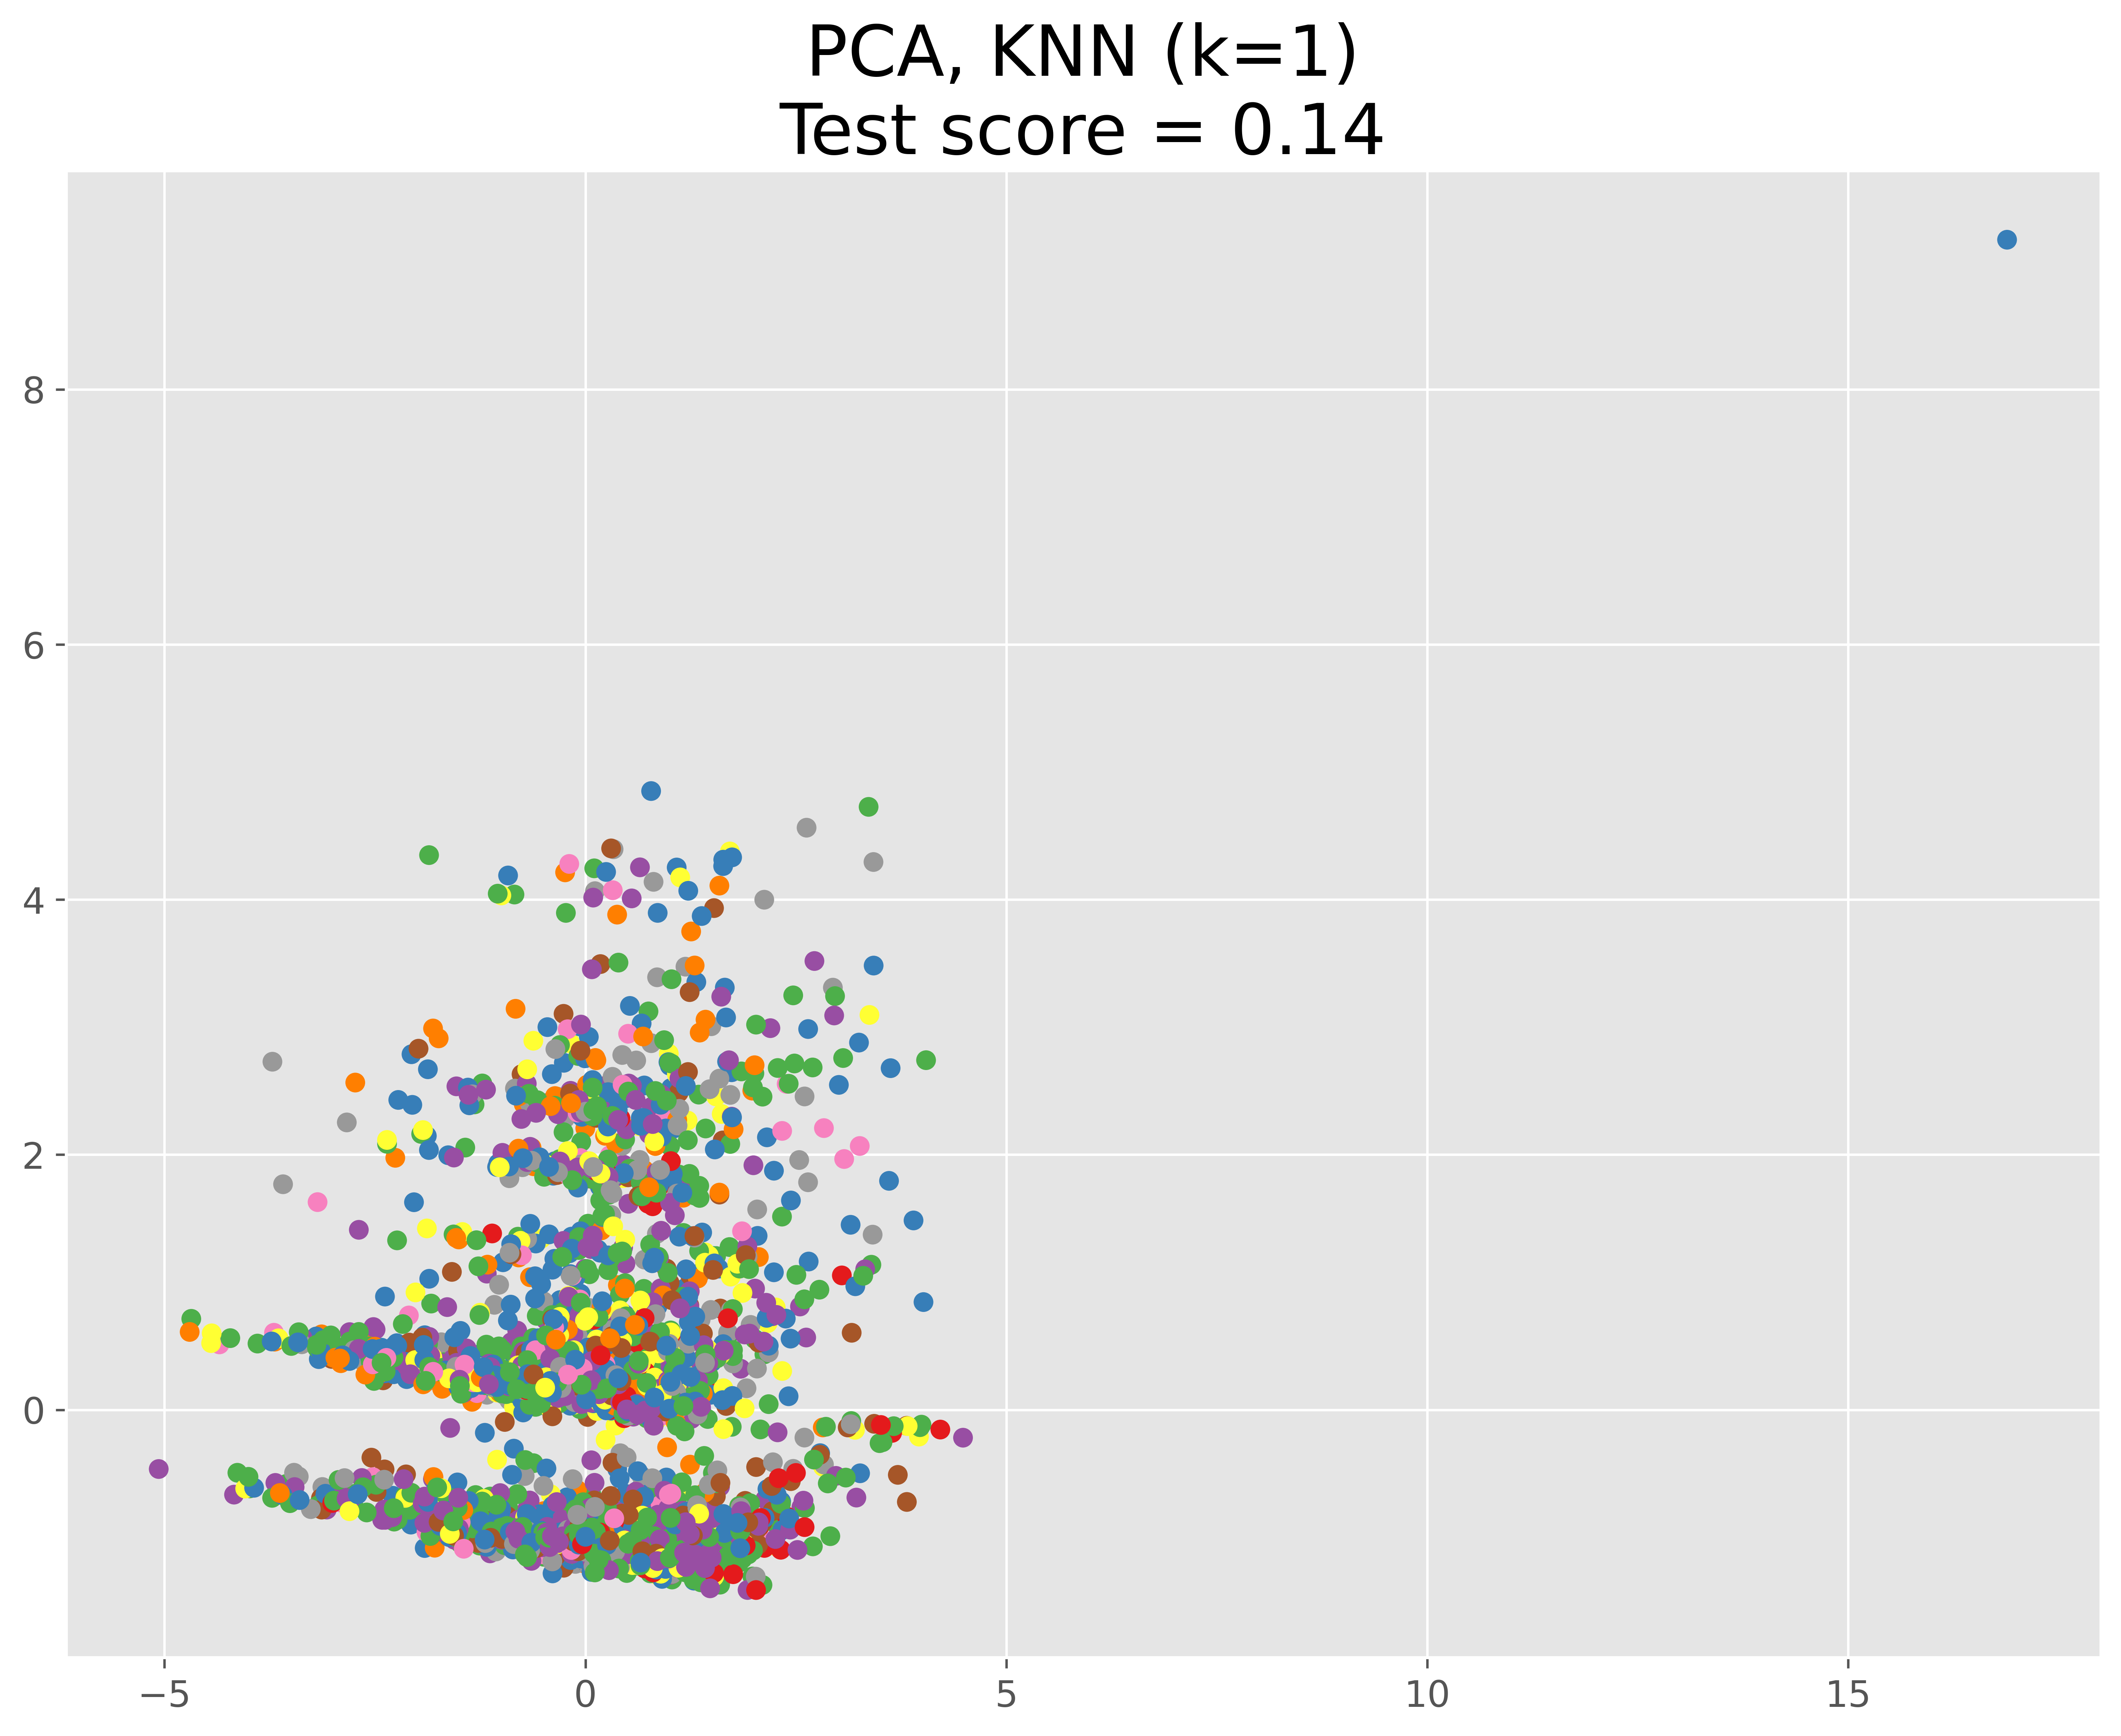

In [40]:

#Set neighbors matrix for grid searching
param_grid = dict(n_neighbors = np.arange(1, 30))

#Hyperparameter tuning by grid searching
print("--------With GridSearch--------")
grid_search = GridSearchCV(knn, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)
optimal_knn = grid_search.best_estimator_
plotKNN(optimal_knn)

print()

--------With Randomized GridSearch--------
Optimal k is 1


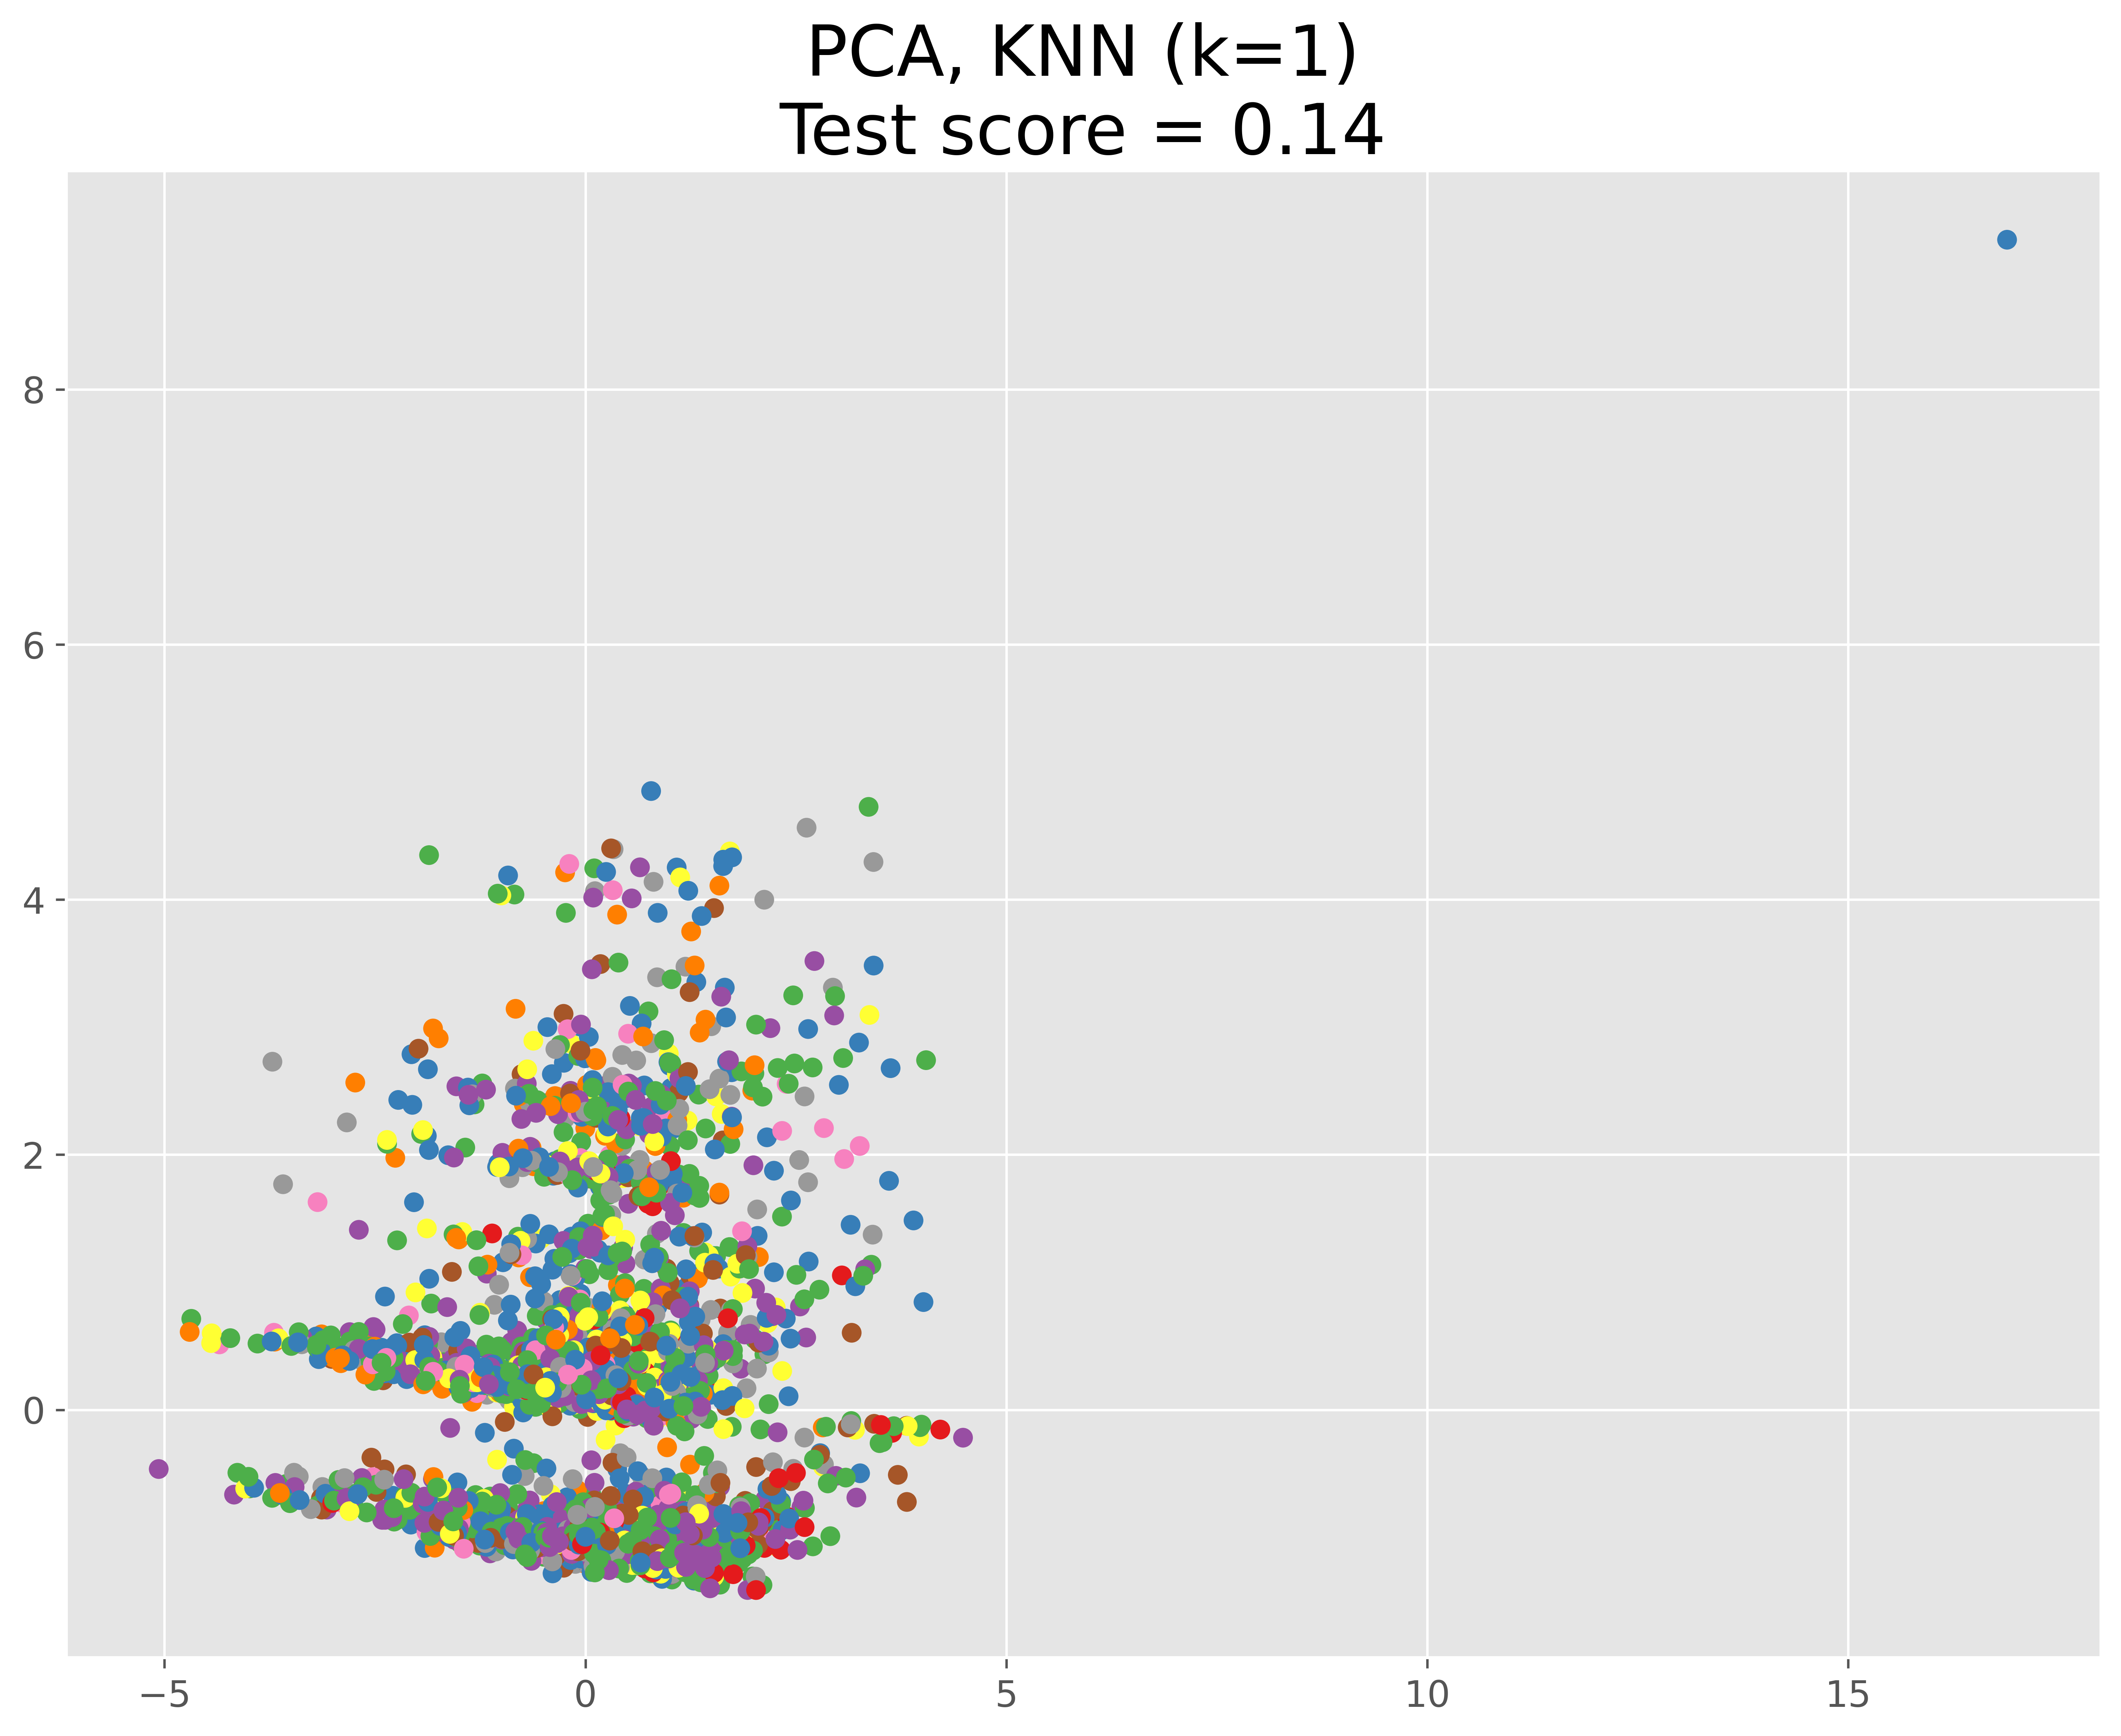

In [41]:
#Hyperparameter tuning by randomized grid searching
print("--------With Randomized GridSearch--------")
randomized_grid_search = RandomizedSearchCV(knn, param_grid, scoring='accuracy', n_jobs=-1, cv=cv)
randomized_grid_search.fit(X_train, y_train)
optimal_knn = grid_search.best_estimator_
print(f'Optimal k is {optimal_knn.n_neighbors}')
plotKNN(optimal_knn)
print()

In [42]:
X = pd.read_csv("preprocessed_feature.csv", index_col=[0])
y = pd.read_csv("preprocessed_target.csv", index_col=[0])

In [43]:
#Load preprocessed dataset
#Split dataset into test and train set using stratify option

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,  random_state=random_state
)

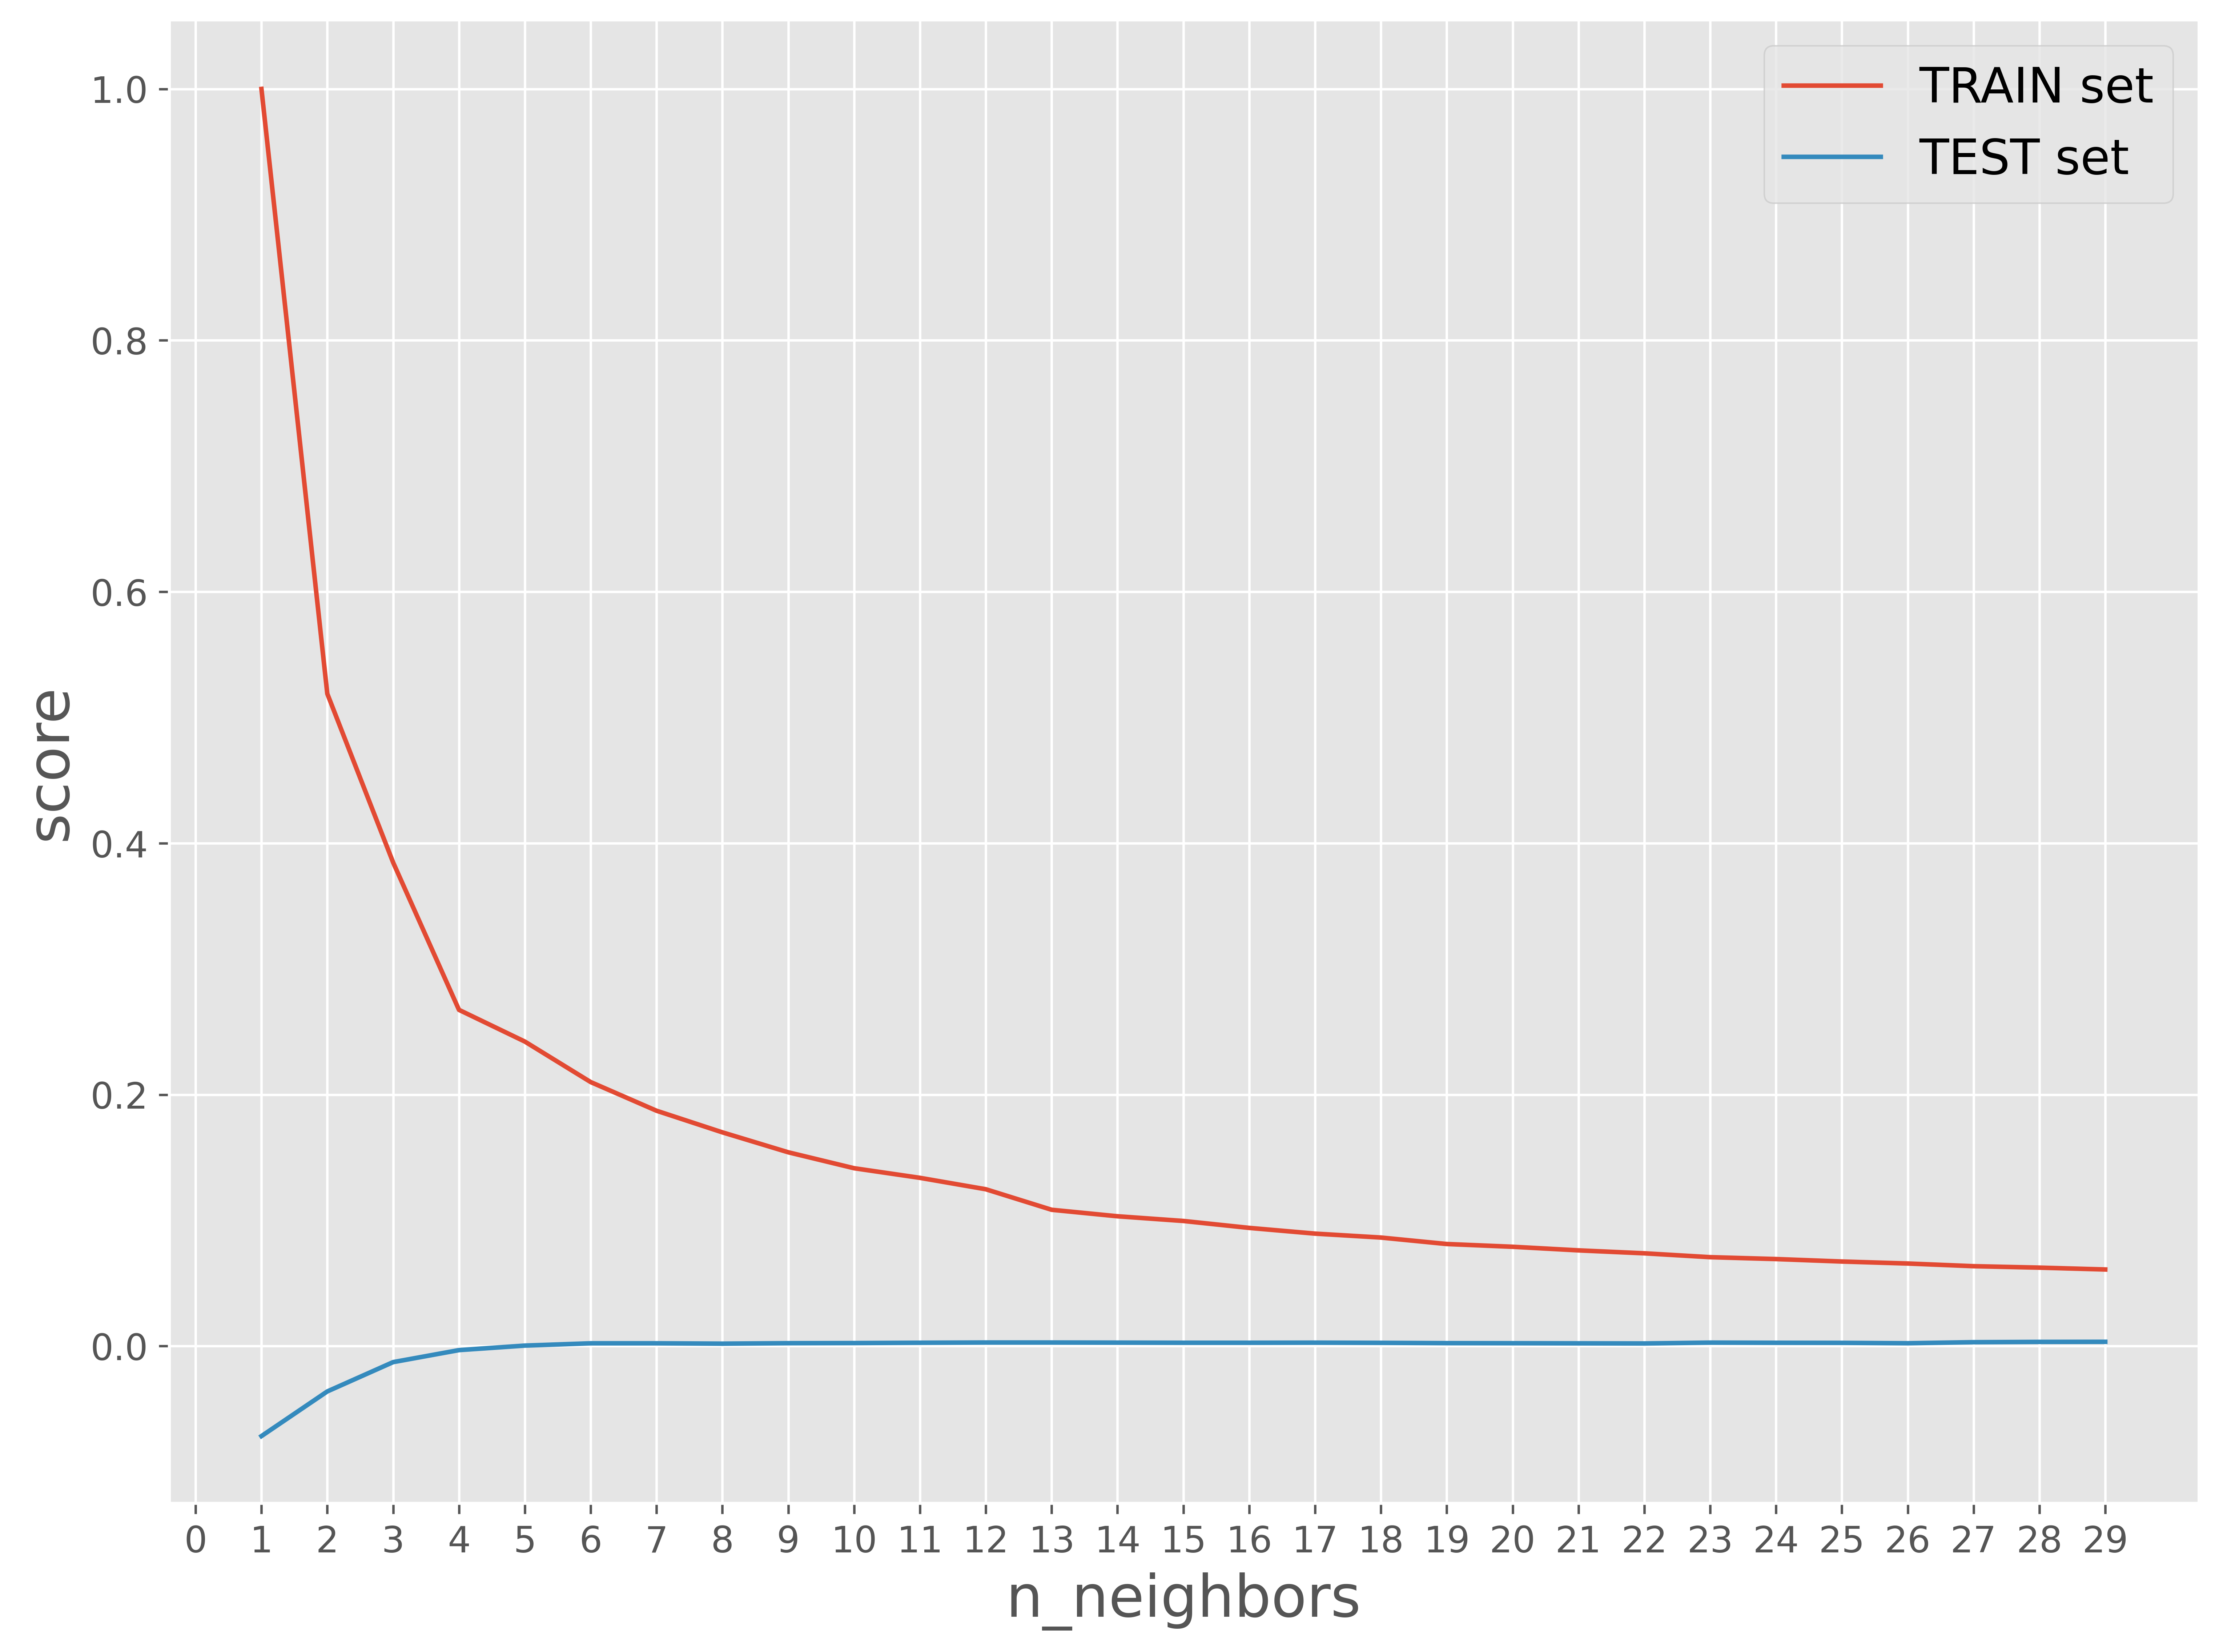

In [44]:
# predict maximum installs by using knnRegressor
clf = KNeighborsRegressor()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

y_test=np.ravel(y_test)

train_acc = []
test_acc = []

#Plot accuracy by changing n_neighbors
for n in range(1,30):
    clf = KNeighborsRegressor(n_jobs=-1, n_neighbors=n)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

plt.figure(figsize=(12, 9))
plt.plot(range(1, 30), train_acc, label='TRAIN set')
plt.plot(range(1, 30), test_acc, label='TEST set')
plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.xticks(np.arange(0, 30, step=1))
plt.legend()
plt.show()